Loaded artefacts: 577 months
Sanity checks passed! ✅



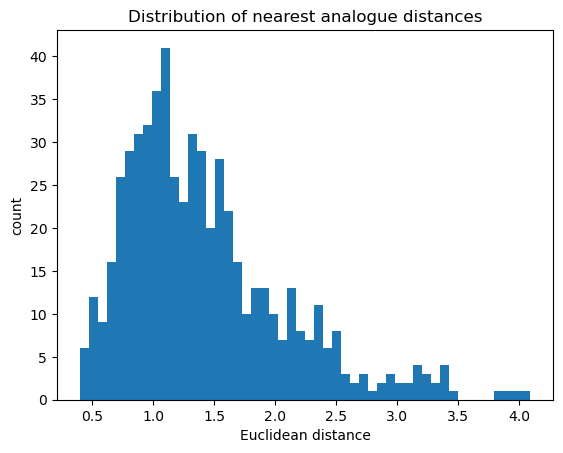

Mean 1‑mo forward S&P return:
  Similar    (≤15 %):  0.9963%
  Dissimilar (≥85 %):  0.0579%



CAGR_strategy      0.029762
CAGR_SPY           0.074182
Sharpe_strategy    0.674601
Sharpe_SPY         0.581149
dtype: float64

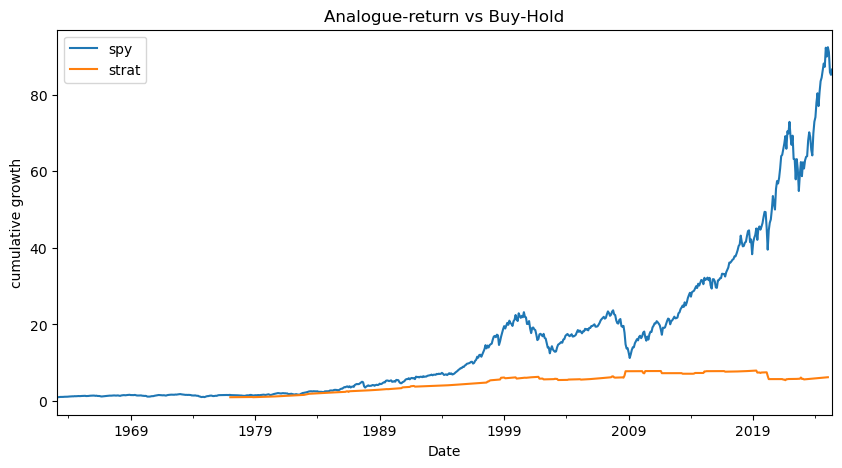

Hit‑rate: 57.27%


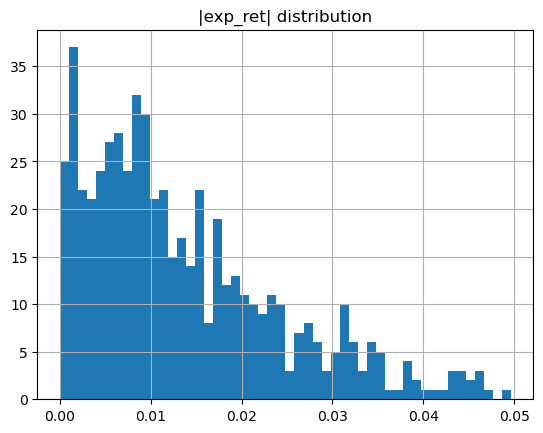

% rows with <K valid peers: 30.5%
Mean |signal|: 0.10051993067590988
90th pct |signal|: 0.39999999999997726


In [1]:
#!/usr/bin/env python3
"""
backtest_analog_strategy.py

Full back‑test notebook as a runnable script, with corrected inverse‑distance weighting.
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1 · Config & imports
DATA_DIR     = Path("../data/processed")
Z_FILE       = DATA_DIR / "macro_zscores_monthly.csv"
IDX_FILE     = DATA_DIR / "analog_idx.npy"
DST_FILE     = DATA_DIR / "analog_dist.npy"
SP_FILE      = DATA_DIR / "sp500_merged.csv"
NBER_FILE    = DATA_DIR / "usrec_monthly.csv"
TB3MS_FILE   = DATA_DIR / "tb3ms.csv"

K_ANALOG     = 5             # how many neighbours to average
STEP_AHEAD   = 1             # forecast horizon in months
MIN_GAP_MTHS = 24            # exclude neighbours < 24 m old
EPS          = 1e-6          # small number for inverse‑distance weighting
THR_QUANT    = 0.90          # quantile threshold for binary signal (top 10%)

# 2 · Load artefacts
z        = pd.read_csv(Z_FILE,    index_col=0, parse_dates=True)
idx_arr  = np.load(IDX_FILE)
dist_arr = np.load(DST_FILE)

sp = (
    pd.read_csv(SP_FILE, parse_dates=["Date"])
      .set_index("Date")["Adj_Close_Combined"]
)
sp.index += pd.offsets.MonthEnd(0)

usrec = (
    pd.read_csv(NBER_FILE, index_col=0, parse_dates=True)["USRECP"]
)
usrec.index += pd.offsets.MonthEnd(0)

fred_m = (
    pd.read_csv(TB3MS_FILE, parse_dates=["DATE"])
      .set_index("DATE")
      .rename(columns={"TB3MS":"DTB3"})
)
fred_m.index += pd.offsets.MonthEnd(0)

print("Loaded artefacts:", len(z), "months")
assert len(z)==idx_arr.shape[0]==dist_arr.shape[0]
assert idx_arr.shape[1]>=K_ANALOG
assert z.isna().sum().sum()==0
print("Sanity checks passed! ✅\n")

# 3 · Distance histogram + forward‑return diagnostic
nearest_d = dist_arr[:,0]
nearest_d = nearest_d[np.isfinite(nearest_d)]

plt.hist(nearest_d, bins=50)
plt.title("Distribution of nearest analogue distances")
plt.xlabel("Euclidean distance"); plt.ylabel("count")
plt.show()

ret     = sp.pct_change()
fwd_ret = ret.shift(-1)

low_q, high_q = np.quantile(nearest_d, [0.15, 0.85])
diag = (
    pd.DataFrame({"dist": nearest_d, "fwd_ret": fwd_ret.values[:len(nearest_d)]})
      .dropna()
)
print("Mean 1‑mo forward S&P return:")
print(f"  Similar    (≤15 %): {diag.loc[diag['dist']<=low_q,  'fwd_ret'].mean(): .4%}")
print(f"  Dissimilar (≥85 %): {diag.loc[diag['dist']>=high_q, 'fwd_ret'].mean(): .4%}\n")

# 4 · Build expected return from analogues (with safe inverse‑distance weighting)
fwd_ret_full = ret.shift(-STEP_AHEAD)
exp_ret = np.empty(len(z))

for i in range(len(z)):
    peers      = idx_arr[i]
    peer_dates = z.index[peers]
    cutoff     = z.index[i] - pd.DateOffset(months=MIN_GAP_MTHS)

    # select old-enough peers, fallback if too few
    valid = [p for p,d in zip(peers, peer_dates) if d<=cutoff]
    sel   = valid[:K_ANALOG] if len(valid)>=K_ANALOG else peers[:K_ANALOG]

    # find positions of selected peers in the sorted list
    pos = [int(np.where(peers==p)[0][0]) for p in sel]

    # compute weighted average of forward returns
    dists = dist_arr[i, pos]
    inv   = 1/(dists + EPS)
    total = inv.sum()
    if total <= EPS:
        exp_ret[i] = np.nan
    else:
        w = inv / total
        returns = fwd_ret_full.loc[z.index[sel]].values
        exp_ret[i] = np.dot(w, returns)

exp_ret = pd.Series(exp_ret, index=z.index, name="analog_exp")

# 5 · Build threshold‑based signal & strategy returns with cash carry
thr = exp_ret.abs().quantile(THR_QUANT)
sig = np.where(exp_ret >=  thr,  1,
      np.where(exp_ret <= -thr, -1,  0))
signal = pd.Series(sig, index=exp_ret.index, name="signal")

signal = signal.reindex(ret.index)
mask   = ret.notna()
signal, ret = signal[mask], ret[mask]

rf = fred_m["DTB3"].reindex(ret.index) / 1200
strat_ret = signal.shift(1)*ret + (signal==0).shift(1)*rf
strat_ret.name = "strat"

# 6 · Performance
def annualised_sharpe(r): return np.sqrt(12)*r.mean()/r.std()

summary = pd.Series({
    "CAGR_strategy":   (1+strat_ret).prod()**(12/len(strat_ret)) - 1,
    "CAGR_SPY":        (1+ret).prod()**(12/len(ret)) - 1,
    "Sharpe_strategy": annualised_sharpe(strat_ret),
    "Sharpe_SPY":      annualised_sharpe(ret)
})
display(summary)

cum = (1+pd.concat([ret.rename("spy"), strat_ret], axis=1)).cumprod()
cum.plot(figsize=(10,5))
plt.title("Analogue‑return vs Buy‑Hold")
plt.ylabel("cumulative growth")
plt.show()

# 7 · Diagnostics
# 7a) Hit‑rate & |exp_ret|
idx_common = ret.index.intersection(exp_ret.index[exp_ret.notna()])
exp_al = exp_ret.shift(1).reindex(idx_common)
ret_al = ret.reindex(idx_common)
fwd_al = ret.shift(-1).reindex(idx_common)

print(f"Hit‑rate: {(np.sign(exp_al)==np.sign(fwd_al)).mean():.2%}")
exp_al.abs().hist(bins=50); plt.title("|exp_ret| distribution"); plt.show()

# 7b) Peer sufficiency
peer_counts = [
    sum(z.index[idx_arr[i]] <= z.index[i] - pd.DateOffset(months=MIN_GAP_MTHS))
    for i in range(len(z))
]
few_pct = np.mean(np.array(peer_counts)<K_ANALOG)*100
print(f"% rows with <K valid peers: {few_pct:.1f}%")

# 7c) Signal stats
print("Mean |signal|:", signal.abs().mean())
print("90th pct |signal|:", signal.abs().quantile(0.9))
